# Capstone Final Project


### This is the code for the capstone final project. 
### Goal: predict where is the location with more potential revenue for client (Delivery app), who is based on Toronto and wants to expand to New York

#### This code is divided in 2 main parts: 
####      - Unsupervised/spatial: where we get FourSquare Data and creat clusters for Toronto and NY neighborhood. In Toronto we find our target cluster: Cluster 3 - location with venues that are customers of our client
####      - Supervised: where we work with data wrangling (categories spatially ordenated and transform data to numerical), visualization (threshold for classification) and prediction (LR and Decision Tree Models)

## Unsupervised Part: Toronto and NY - getting Data, Clustering and Spatial configuration

###  Toronto Data

### dataframe: PostalCode, Borough, and Neighborhood

In [2]:
## Scrapping usig Pandas

import pandas as pd

dfl=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')

In [4]:
a=dfl[0]
a.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
## Removing "Not assigned" from Borough and replacing "Not assigned" in Neighbourhood

a1=a[a.Borough != "Not assigned"]
a1.iloc[:,2].replace("Not assigned",a1.iloc[:,1],inplace=True)

In [6]:
## colapsing the data set
b1=pd.DataFrame(a1.groupby('Postcode')['Neighbourhood'].apply(lambda x: ','.join(x))).reset_index()
b2=pd.DataFrame(a1.groupby('Postcode')['Borough'].apply(lambda x: x.unique().sum())).reset_index()
dft=pd.concat([b2,b1['Neighbourhood']],axis=1)
dft.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
dft.shape

(103, 3)

#### Dataframe:getting lat and lon for


In [8]:
### Getting lat and long from csv file

dfc = pd.read_csv("http://cocl.us/Geospatial_data")
dfc.shape


(103, 3)

In [236]:
dfc1=dfc.sort_values(by=['Postal Code'])


In [10]:
### creating the data set with lat and lon

dfc1=dfc1[['Latitude','Longitude']]
dft1=dft.sort_values(by=['Postcode'])
dff=pd.concat([dft1,dfc1], axis=1)
dff.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
## Since I am using IBM Watson, for a reason that I do not know why, I need to get folium
import sys
!{sys.executable} -m pip install folium

     |████████████████████████████████| 92kB 13.9MB/s eta 0:00:01


### Clustering: getting data from foursquare, wreagling, data base preparation, model K-means, map and cluster individual data set

In [12]:
## importing 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium

In [13]:
dff=dff.iloc[:,1:5].reset_index(drop=True)

In [14]:
## Credentials

CLIENT_ID = 'BT35TDL3QERQQHKUKT43CJT4TBARGZBTCIITMSDSRLZ1YLXF' # your Foursquare ID
CLIENT_SECRET = '3JRQQ5J3MAH1KR5HV10CUWYJ3AE3ZIUQL5OFWH054NO0QAXM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BT35TDL3QERQQHKUKT43CJT4TBARGZBTCIITMSDSRLZ1YLXF
CLIENT_SECRET:3JRQQ5J3MAH1KR5HV10CUWYJ3AE3ZIUQL5OFWH054NO0QAXM


In [15]:
## function to get data venues from Foursquare 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
## applying the function to get venues

LIMIT=15
toronto_venues = getNearbyVenues(names=dff['Neighbourhood'],
                                   latitudes=dff['Latitude'],
                                   longitudes=dff['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [17]:
### retrive information if some troubleshoot happens with FourSquare

### save as csv
import csv

#export_csv = toronto_venues.to_csv (r'C:\Users\rapha\Desktop\Capstone\toronto_venues2.csv', index = None, header=True)

#ny_venues.to_csv(r'C:\Users\rapha\OneDrive\Py_Rph\Coursera\Capstone\ny_venues2.csv')

###read
#toronto_venues2= pd.read_csv(r'C:\Users\rapha\Desktop\Capstone\toronto_venues.csv', delimiter=",")

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(909, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge,Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [242]:
# Number of venues were returned for each neighborhood
d=toronto_venues.groupby('Neighborhood').count()

#### Data Prepartion for clustering

In [243]:
## transforme categorical data into numerical data

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

del(toronto_onehot['Neighborhood'])

# move neighborhood column to the first column
dkonehot=pd.concat([toronto_venues['Neighborhood'],toronto_onehot],axis=1)



In [244]:
## Groupby in order to get the means of the number of venue categories 
dk = dkonehot.groupby(dkonehot['Neighborhood']).mean().reset_index()
dk.shape

(100, 206)

In [323]:
dk

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Pool,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.00,0.000000,0.000000,0.066667,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.066667,0.000000,0.000000,0.066667,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [245]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [246]:
#new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dk['Neighborhood']

for ind in np.arange(dk.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dk.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Steakhouse,Coffee Shop,Pizza Place,Speakeasy,Bar,Hotel,Plaza,Asian Restaurant,Food Court,Seafood Restaurant
1,Agincourt,Breakfast Spot,Chinese Restaurant,Sandwich Place,Lounge,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Asian Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pharmacy,Fast Food Restaurant,Liquor Store,Sandwich Place,Fried Chicken Joint,Beer Store,Video Store,Coffee Shop,Pizza Place
4,"Alderwood,Long Branch",Pizza Place,Gym,Skating Rink,Dance Studio,Coffee Shop,Pool,Pub,Sandwich Place,Pharmacy,Art Gallery


#### Cluster Model

In [247]:
## Cluster Model

# set number of clusters
kclusters = 7

toronto_grouped_clustering = dk.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 6, 1, 1, 1, 2, 2, 2, 2], dtype=int32)

In [248]:
##Adding Clustering Labels to final DataFrame

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dff

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood').dropna()



#### clusters on a Map

In [27]:
### Toronto location

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.653963, -79.387207.


In [28]:
# visualize the resulting clusters on a Map

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster-1)],
        fill=True,
        fill_color=rainbow[round(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

####  Examine Clusters

In [249]:
clto1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


In [30]:
clto2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto2

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Rouge,Malvern",Fast Food Restaurant,Print Shop,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner
2,"Guildwood,Morningside,West Hill",Electronics Store,Mexican Restaurant,Breakfast Spot,Pizza Place,Medical Center,Intersection,Rental Car Location,Spa,Tech Startup,Eastern European Restaurant
12,Agincourt,Breakfast Spot,Chinese Restaurant,Sandwich Place,Lounge,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
13,"Clarks Corners,Sullivan,Tam O'Shanter",Pizza Place,Pharmacy,Fried Chicken Joint,Bank,Thai Restaurant,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Noodle House,Discount Store
15,L'Amoreaux West,Chinese Restaurant,Fast Food Restaurant,Pharmacy,American Restaurant,Pizza Place,Sandwich Place,Breakfast Spot,Thrift / Vintage Store,Coffee Shop,Grocery Store
24,Willowdale West,Pharmacy,Pizza Place,Discount Store,Coffee Shop,Grocery Store,Airport Lounge,Farmers Market,Event Space,Empanada Restaurant,Electronics Store
28,"Bathurst Manor,Downsview North,Wilson Heights",Coffee Shop,Pharmacy,Deli / Bodega,Restaurant,Bridal Shop,Bank,Sushi Restaurant,Sandwich Place,Fast Food Restaurant,Fried Chicken Joint
31,Downsview West,Grocery Store,Shopping Mall,Bank,Yoga Studio,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
33,Downsview Northwest,Grocery Store,Athletics & Sports,Discount Store,Liquor Store,Gym / Fitness Center,Concert Hall,Dim Sum Restaurant,Falafel Restaurant,Event Space,Empanada Restaurant
35,"Woodbine Gardens,Parkview Hill",Fast Food Restaurant,Pizza Place,Intersection,Athletics & Sports,Café,Breakfast Spot,Pharmacy,Gastropub,Gym / Fitness Center,Pet Store


In [31]:
clto3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto3

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek,Rouge Hill,Port Union",Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
4,Cedarbrae,Caribbean Restaurant,Lounge,Bakery,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Bank,Diner,Dog Run
7,"Clairlea,Golden Mile,Oakridge",Bus Line,Bakery,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Creperie,Cuban Restaurant
8,"Cliffcrest,Cliffside,Scarborough Village West",Motel,American Restaurant,Yoga Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner
9,"Birch Cliff,Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
10,"Dorset Park,Scarborough Town Centre,Wexford He...",Indian Restaurant,Latin American Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
11,"Maryvale,Wexford",Middle Eastern Restaurant,Shopping Mall,Sandwich Place,Bakery,Auto Garage,Breakfast Spot,Yoga Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant
17,Hillcrest Village,Golf Course,Mediterranean Restaurant,Pool,Dog Run,Yoga Studio,Dance Studio,Eastern European Restaurant,Drugstore,Discount Store,Diner
18,"Fairview,Henry Farm,Oriole",Tea Room,Movie Theater,Smoothie Shop,Shopping Mall,Juice Bar,Burger Joint,Fast Food Restaurant,Bakery,Department Store,Candy Store
19,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run


In [32]:
clto4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto4

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Woburn,Coffee Shop,Korean Restaurant,Convenience Store,Dessert Shop,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
6,"East Birchmount Park,Ionview,Kennedy Park",Playground,Discount Store,Department Store,Coffee Shop,Yoga Studio,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore
34,Victoria Village,Coffee Shop,Portuguese Restaurant,Hockey Arena,Intersection,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
40,East Toronto,Coffee Shop,Park,Convenience Store,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
46,North Toronto West,Coffee Shop,Yoga Studio,Bagel Shop,Gym / Fitness Center,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant,Park,Chinese Restaurant
53,"Harbourfront,Regent Park",Coffee Shop,Breakfast Spot,Bakery,Chocolate Shop,Pub,Restaurant,Spa,Farmers Market,Park,Gym / Fitness Center
57,Central Bay Street,Coffee Shop,Ramen Restaurant,Sushi Restaurant,Gastropub,Park,Spa,Bubble Tea Shop,Pizza Place,Seafood Restaurant,Tea Room
85,Queen's Park,Coffee Shop,Park,Yoga Studio,Sushi Restaurant,Arts & Crafts Store,Creperie,Diner,Hobby Shop,Italian Restaurant,Mexican Restaurant
86,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,Gym / Fitness Center,Mediterranean Restaurant,Burrito Place,American Restaurant,Sandwich Place,Fried Chicken Joint,Department Store,Eastern European Restaurant


In [33]:
clto5=toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto5

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,"Humber Bay,King's Mill Park,Kingsway Park Sout...",Baseball Field,Yoga Studio,Farmers Market,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
97,"Emery,Humberlea",Baseball Field,Yoga Studio,Farmers Market,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store


In [34]:
clto6=toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto6

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Silver Hills,York Mills",Cafeteria,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner,Dim Sum Restaurant


In [35]:
clto7=toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clto7

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Asian Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
23,York Mills West,Park,Convenience Store,Bar,Bank,Yoga Studio,Dim Sum Restaurant,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant
25,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
30,"CFB Toronto,Downsview East",Airport,Park,Other Repair Shop,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
44,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
50,Rosedale,Park,Playground,Building,Trail,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
64,"Forest Hill North,Forest Hill West",Park,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
74,Caledonia-Fairbanks,Park,Pharmacy,Women's Store,Market,Fast Food Restaurant,Deli / Bodega,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
90,"The Kingsway,Montgomery Road,Old Mill North",River,Park,Pool,Curling Ice,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner,Dim Sum Restaurant
98,Weston,Park,Yoga Studio,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner


### New York Data 



In [36]:
## Getting NY Data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [37]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# a list of the neighborhoods. So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']


###Tranform the data into a pandas dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [38]:
    address = 'New York City, NY'

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [39]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [40]:
### Let's get Data from FourSquare for NY Venues

ny_data=neighborhoods

ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [41]:
print(ny_venues.shape)
ny_venues.head()

(3907, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [42]:
### retrive information if some troubleshoot happens with FourSquare

### save as csv
import csv

export_csv = ny_venues.to_csv (r'C:\Users\rapha\Desktop\Capstone\ny_venues2.csv', index = None, header=True)

#ny_venues.to_csv(r'C:\Users\rapha\OneDrive\Py_Rph\Coursera\Capstone\ny_venues2.csv')

###read
#ny_venues2= pd.read_csv(r'C:\Users\rapha\Desktop\Capstone\ny_venues2.csv', delimiter=",")

In [43]:
## transforme categorical data into numerical data

# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

del(ny_onehot['Neighborhood'])

# move neighborhood column to the first column
nydkonehot=pd.concat([ny_venues['Neighborhood'],ny_onehot],axis=1)

nydkonehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Servic

In [250]:
## Groupby in order to get the means of the number of venue categories 

nydk = nydkonehot.groupby(nydkonehot['Neighborhood']).mean().reset_index()



In [48]:
nydk.shape

(302, 338)

In [49]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [312]:
#new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nydk['Neighborhood']

for ind in np.arange(dk.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nydk.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Breakfast Spot,Martial Arts Dojo,Dessert Shop,Discount Store,Donut Shop,Pharmacy,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,Annadale,Pizza Place,Restaurant,Pharmacy,Train Station,Food,Sports Bar,Park,Diner,Food Truck,Event Space
2,Arden Heights,Pizza Place,Pharmacy,Coffee Shop,Bus Stop,Yoga Studio,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
3,Arlington,Deli / Bodega,American Restaurant,Grocery Store,Boat or Ferry,Bus Stop,Food,Food Truck,Fountain,Food Court,French Restaurant
4,Arrochar,Deli / Bodega,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Hotel,Liquor Store,Outdoors & Recreation,Supermarket,Cosmetics Shop,Mediterranean Restaurant


#### Cluster Model for NY

In [100]:
## Cluster Model

# same number of clusters used with Toronto
kclusters = 8

ny_grouped_clustering = nydk.drop('Neighborhood', 1)

# run k-means clustering
kmeansny = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeansny.labels_[0:10] 

array([5, 5, 5, 4, 4, 2, 7, 7, 7, 7], dtype=int32)

In [313]:
##Adding Clustering Labels to final DataFrame

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeansny.labels_)

ny_merged = ny_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').dropna()

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bronx,Co-op City,40.874294,-73.829939,2,Restaurant,Bus Station,Baseball Field,Gift Shop,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Grocery Store,Basketball Court,Discount Store
2,Bronx,Eastchester,40.887556,-73.827806,2,Caribbean Restaurant,Diner,Seafood Restaurant,Bowling Alley,Fast Food Restaurant,Automotive Shop,Food & Drink Shop,Pizza Place,Bus Stop,Business Service
3,Bronx,Fieldston,40.895437,-73.905643,2,Playground,Bus Station,River,High School,Plaza,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
10,Bronx,Baychester,40.866858,-73.835798,2,Fried Chicken Joint,Arcade,Bank,Pet Store,Mexican Restaurant,Supermarket,Pizza Place,Convenience Store,Donut Shop,Breakfast Spot
12,Bronx,City Island,40.847247,-73.786488,7,Ice Cream Shop,Seafood Restaurant,Deli / Bodega,Pizza Place,Music Venue,Smoke Shop,Bar,Bank,History Museum,French Restaurant


In [126]:
# visualize the resulting NY clusters on a Map

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster-1)],
        fill=True,
        fill_color=rainbow[round(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

####  Examine NY Clusters

In [314]:
clny1=ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Clason Point,Park,Grocery Store,Pool,Bus Stop,South American Restaurant,Boat or Ferry,Business Service,Scenic Lookout,Fish & Chips Shop,Farm
238,Butler Manor,Baseball Field,Pool,Bus Stop,Convenience Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
245,Bloomfield,Recreation Center,Discount Store,Theme Park,Bus Stop,Park,Food Court,Filipino Restaurant,Falafel Restaurant,French Restaurant,Farm
303,Bayswater,Park,Tennis Court,Playground,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


In [315]:
clny2=ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,Beach,Monument / Landmark,American Restaurant,Trail,Board Shop,Yoga Studio,Flower Shop,Fast Food Restaurant,Field,Filipino Restaurant
190,Belle Harbor,Beach,Deli / Bodega,Pub,Donut Shop,Chinese Restaurant,Bakery,Bagel Shop,Mexican Restaurant,Boutique,Ice Cream Shop
255,Emerson Hill,Casino,Sculpture Garden,Yoga Studio,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop


In [316]:
clny3=ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Restaurant,Bus Station,Baseball Field,Gift Shop,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Grocery Store,Basketball Court,Discount Store
2,Eastchester,Caribbean Restaurant,Diner,Seafood Restaurant,Bowling Alley,Fast Food Restaurant,Automotive Shop,Food & Drink Shop,Pizza Place,Bus Stop,Business Service
3,Fieldston,Playground,Bus Station,River,High School,Plaza,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
10,Baychester,Fried Chicken Joint,Arcade,Bank,Pet Store,Mexican Restaurant,Supermarket,Pizza Place,Convenience Store,Donut Shop,Breakfast Spot
29,Country Club,Sandwich Place,Fried Chicken Joint,Italian Restaurant,Trail,Playground,Liquor Store,Deli / Bodega,Food Truck,Filipino Restaurant,Factory
43,Concourse,Fried Chicken Joint,Donut Shop,Caribbean Restaurant,Sandwich Place,Bakery,Pharmacy,Grocery Store,Pizza Place,Art Museum,Chinese Restaurant
45,Edenwald,Fried Chicken Joint,Gas Station,Bus Station,Grocery Store,Food,Chinese Restaurant,Pizza Place,Fish Market,Fish & Chips Shop,Farm
54,Flatbush,Coffee Shop,Mexican Restaurant,Pizza Place,Chinese Restaurant,Bank,Sandwich Place,Bagel Shop,Caribbean Restaurant,Middle Eastern Restaurant,Juice Bar
56,East Flatbush,Department Store,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Bakery,Hardware Store,Supermarket,Pharmacy,Park,Print Shop
60,Brownsville,Restaurant,Park,Farmers Market,Performing Arts Venue,Donut Shop,Pizza Place,Convenience Store,Moving Target,Spanish Restaurant,Discount Store


In [317]:
clny4=ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Bushwick,Bar,Mexican Restaurant,Deli / Bodega,Pizza Place,Coffee Shop,Latin American Restaurant,Sandwich Place,Used Bookstore,Thrift / Vintage Store,French Restaurant
63,Bedford Stuyvesant,Bar,Coffee Shop,Juice Bar,Gourmet Shop,Boutique,Japanese Restaurant,Pizza Place,Vietnamese Restaurant,Fried Chicken Joint,New American Restaurant
95,East Williamsburg,Coffee Shop,Bar,Cocktail Bar,Bakery,Deli / Bodega,Dive Bar,Donut Shop,Gay Bar,Vegetarian / Vegan Restaurant,Café


In [318]:
clny5=ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Belmont,Deli / Bodega,Italian Restaurant,Pizza Place,Food & Drink Shop,Dessert Shop,Fish Market,Bakery,Market,Fountain,Food Truck
39,Edgewater Park,Italian Restaurant,Pizza Place,Deli / Bodega,Pub,Park,Coffee Shop,Bar,Asian Restaurant,Sports Bar,American Restaurant
159,Briarwood,Deli / Bodega,Indian Restaurant,Gym,Bus Station,Fast Food Restaurant,Coffee Shop,Convenience Store,Mexican Restaurant,Arts & Crafts Store,Yoga Studio
171,Broad Channel,Deli / Bodega,Dive Bar,Other Nightlife,Pizza Place,Bus Station,Park,Food Court,Food & Drink Shop,Food Truck,Food
193,Brookville,Deli / Bodega,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market
194,Bellaire,Deli / Bodega,Italian Restaurant,Grocery Store,Bus Station,Moving Target,Bus Stop,Greek Restaurant,Coffee Shop,Convenience Store,Chinese Restaurant
227,Arlington,Deli / Bodega,American Restaurant,Grocery Store,Boat or Ferry,Bus Stop,Food,Food Truck,Fountain,Food Court,French Restaurant
228,Arrochar,Deli / Bodega,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Hotel,Liquor Store,Outdoors & Recreation,Supermarket,Cosmetics Shop,Mediterranean Restaurant
258,Elm Park,Deli / Bodega,Ice Cream Shop,Italian Restaurant,American Restaurant,Pizza Place,Cosmetics Shop,Fish Market,Falafel Restaurant,Farm,Farmers Market


In [319]:
clny6=ny_merged.loc[ny_merged['Cluster Labels'] == 5, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Bedford Park,Diner,Supermarket,Pizza Place,Mexican Restaurant,Park,Deli / Bodega,Pub,Bar,Sandwich Place,Fish & Chips Shop
17,East Tremont,Pizza Place,Café,Paella Restaurant,Lounge,Breakfast Spot,Discount Store,Shoe Store,Supermarket,Bank,Mobile Phone Shop
40,Castle Hill,Deli / Bodega,Bus Station,Bank,Market,Pharmacy,Pizza Place,Park,Spanish Restaurant,Diner,Food Court
55,Crown Heights,Pizza Place,Museum,Café,Playground,Candy Store,Bakery,Bagel Shop,Salon / Barbershop,Coffee Shop,Burger Joint
78,Coney Island,Caribbean Restaurant,Pizza Place,Brewery,Pharmacy,Music Venue,Monument / Landmark,Food Court,Café,Skating Rink,Gourmet Shop
80,Borough Park,Bank,Pizza Place,Coffee Shop,Deli / Bodega,American Restaurant,Fast Food Restaurant,Hotel,Restaurant,Café,Pharmacy
156,Bellerose,Pizza Place,Deli / Bodega,Chinese Restaurant,Wine Shop,Pub,Diner,American Restaurant,Grocery Store,Italian Restaurant,Bank
170,Far Rockaway,Pizza Place,Fried Chicken Joint,Bank,Chinese Restaurant,Breakfast Spot,Fast Food Restaurant,Supermarket,Caribbean Restaurant,Donut Shop,Sandwich Place
176,Edgemere,Metro Station,Pizza Place,Park,Deli / Bodega,Bus Station,Seafood Restaurant,Farm,Scenic Lookout,Skate Park,Gift Shop
181,Floral Park,Indian Restaurant,Hobby Shop,Wine Shop,Grocery Store,Pizza Place,Basketball Court,Yoga Studio,Falafel Restaurant,Farm,Farmers Market


In [320]:
clny7=ny_merged.loc[ny_merged['Cluster Labels'] == 6, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny7

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [321]:
clny8=ny_merged.loc[ny_merged['Cluster Labels'] == 7, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
clny8

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,City Island,Ice Cream Shop,Seafood Restaurant,Deli / Bodega,Pizza Place,Music Venue,Smoke Shop,Bar,Bank,History Museum,French Restaurant
46,Bay Ridge,Grocery Store,Spa,Pizza Place,Greek Restaurant,Caucasian Restaurant,Bagel Shop,Taco Place,Middle Eastern Restaurant,Bookstore,Juice Bar
47,Bensonhurst,Ice Cream Shop,Sushi Restaurant,Shabu-Shabu Restaurant,Bagel Shop,Liquor Store,Italian Restaurant,Chinese Restaurant,Butcher,Noodle House,Cosmetics Shop
51,Brighton Beach,Varenyky restaurant,Sushi Restaurant,Gourmet Shop,Mediterranean Restaurant,Other Great Outdoors,Korean Restaurant,Pharmacy,Eastern European Restaurant,Beach,Dessert Shop
64,Brooklyn Heights,Yoga Studio,Pet Store,Asian Restaurant,Diner,Pizza Place,Coffee Shop,Sushi Restaurant,Gym,Gym / Fitness Center,History Museum
65,Cobble Hill,Cocktail Bar,Italian Restaurant,Spanish Restaurant,Japanese Restaurant,Seafood Restaurant,Bar,Men's Store,Bookstore,Pilates Studio,Gastropub
66,Carroll Gardens,Coffee Shop,Arts & Crafts Store,Spa,Butcher,Café,Greek Restaurant,Farmers Market,Park,Cocktail Bar,Bar
79,Bath Beach,Italian Restaurant,Ice Cream Shop,Turkish Restaurant,Pizza Place,Restaurant,Coffee Shop,Park,Burger Joint,Surf Spot,Sushi Restaurant
81,Dyker Heights,Dance Studio,Burger Joint,School,Bagel Shop,Hot Dog Joint,Playground,Golf Course,Filipino Restaurant,Falafel Restaurant,Farm
84,Clinton Hill,Yoga Studio,Bar,Italian Restaurant,Gourmet Shop,Optical Shop,Falafel Restaurant,Pet Store,Pie Shop,Pub,Restaurant


## Supervised Part

#### Let's see NY's cluster size in terms of Neighborhood

In [322]:
print(len(clny1),len(clny2),len(clny3),len(clny4),len(clny5),len(clny6),len(clny7),len(clny8))

4 3 31 3 9 17 0 35


#### Let's see Toronto's cluster size in terms of Neighborhood

In [260]:
print(len(clto1),len(clto2),len(clto3),len(clto4),len(clto5),len(clto6),len(clto7))

2 19 56 9 2 1 11


#### In Toronto, cluster 3 is our principal cluster. So, it is with cluster 3 that we will compare NY's clusters
##### Let's take a look in Toronto's cluster 3 categorical Data


In [261]:
clto3

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Highland Creek,Rouge Hill,Port Union",Construction & Landscaping,Bar,Yoga Studio,Dessert Shop,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
4,Cedarbrae,Caribbean Restaurant,Lounge,Bakery,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Bank,Diner,Dog Run
7,"Clairlea,Golden Mile,Oakridge",Bus Line,Bakery,Park,Intersection,Fast Food Restaurant,Metro Station,Bus Station,Soccer Field,Creperie,Cuban Restaurant
8,"Cliffcrest,Cliffside,Scarborough Village West",Motel,American Restaurant,Yoga Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store,Diner
9,"Birch Cliff,Cliffside West",College Stadium,General Entertainment,Skating Rink,Café,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run,Discount Store
10,"Dorset Park,Scarborough Town Centre,Wexford He...",Indian Restaurant,Latin American Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Deli / Bodega,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run
11,"Maryvale,Wexford",Middle Eastern Restaurant,Shopping Mall,Sandwich Place,Bakery,Auto Garage,Breakfast Spot,Yoga Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant
17,Hillcrest Village,Golf Course,Mediterranean Restaurant,Pool,Dog Run,Yoga Studio,Dance Studio,Eastern European Restaurant,Drugstore,Discount Store,Diner
18,"Fairview,Henry Farm,Oriole",Tea Room,Movie Theater,Smoothie Shop,Shopping Mall,Juice Bar,Burger Joint,Fast Food Restaurant,Bakery,Department Store,Candy Store
19,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Dog Run


#### on a first look, Coffe, Coffe Shops, Gym are the types of customer the our client have

## Data Preparation

#### We need to transform this categorical information in to numerical, to get more deep insights about Toronto Cluster3 e from NY Cluster

In [262]:
##Function to criate data: transform Most Common Venues in numbers and colapse categories in order to know how many categories for each most common venue colum 

def numf(data):
    d1=data.groupby('1st Most Common Venue').count()
    d2=data.groupby('2nd Most Common Venue').count()
    d3=data.groupby('3rd Most Common Venue').count()
    d4=data.groupby('4th Most Common Venue').count()
    d5=data.groupby('5th Most Common Venue').count()
    d6=data.groupby('6th Most Common Venue').count()
    d7=data.groupby('7th Most Common Venue').count()
    d8=data.groupby('8th Most Common Venue').count()
    d9=data.groupby('9th Most Common Venue').count()
    d10=data.groupby('10th Most Common Venue').count()
    df=pd.DataFrame(pd.concat([d1.iloc[:,0],d2.iloc[:,0],d3.iloc[:,0],d4.iloc[:,0],d5.iloc[:,0],d6.iloc[:,0],d7.iloc[:,0],d8.iloc[:,0],d9.iloc[:,0],d10.iloc[:,0]],axis=1))
    df.columns=data.columns[1:len(data.columns)]
    return df

In [263]:
g=numf(clto3).fillna(0.0)
g

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Accessories Store,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Gate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Airport Lounge,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Service,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airport Terminal,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
American Restaurant,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
Art Gallery,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Arts & Crafts Store,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Asian Restaurant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
Athletics & Sports,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### In above Data Frame you can see that there are 9 places of category Coffe for 1st Most Common Venue. But let's colapse this data

In [264]:
## aggregate
gsum=g.sum(axis = 1, skipna = True)
h1=gsum.reset_index().rename(columns={"index": "categ", 0:"clot3"})
h1

,categ,clot3
0,Accessories Store,1.0
1,Airport Gate,1.0
2,Airport Lounge,1.0
3,Airport Service,1.0
4,Airport Terminal,1.0
5,American Restaurant,6.0
6,Art Gallery,2.0
7,Arts & Crafts Store,2.0
8,Asian Restaurant,2.0
9,Athletics & Sports,2.0


##### These are the most important categories in Toronto Cluster 3. They are the kind of vanues that is our client typical client

In [265]:
## most important categories for principal revenue cluster

o1=h1.sort_values(by=['clot3'], axis=0, ascending=False)
o1.head(10)

,categ,clot3
33,Café,23.0
42,Coffee Shop,18.0
62,Eastern European Restaurant,16.0
138,Restaurant,14.0
60,Dog Run,14.0
15,Bakery,13.0
63,Electronics Store,13.0
61,Drugstore,13.0
169,Yoga Studio,12.0
104,Italian Restaurant,12.0


In [266]:
### Classification "y" for modelling most potention categories base on average of mos common customer(venues) in Toronto Cluster 3

dfA = pd.DataFrame(0,index=range(0,len(h1)),columns=['A'])

for i in range(0,len(dfA)):
    if h1['clot3'].iloc[i] >= 3:
        dfA.iloc[i,0] = 1.0
    else:
        dfA.iloc[i,0] = 0

In [267]:
### Data Frame for the model 
dfcl3=pd.concat([g.reset_index(),dfA],axis=1).rename(columns={"index": "categ"})

##### ny clusters data

In [268]:
## Data for NY clusters 2,4 and 8

g2=numf(clny2).fillna(0.0)
g4=numf(clny4).fillna(0.0)
g8=numf(clny8).fillna(0.0)

## agregate
g2sum=g2.sum(axis = 1, skipna = True)
h2=g2sum.reset_index().rename(columns={"index": "categ", 0:"clny2"})

g4sum=g4.sum(axis = 1, skipna = True)
h4=g4sum.reset_index().rename(columns={"index": "categ", 0:"clny4"})

g8sum=g8.sum(axis = 1, skipna = True)
h8=g8sum.reset_index().rename(columns={"index": "categ", 0:"clny8"})


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [269]:
o2=h2.sort_values(by=["clny2"], axis=0, ascending=False)
o4=h4.sort_values(by=["clny4"], axis=0, ascending=False)
o8=h8.sort_values(by=["clny8"], axis=0, ascending=False)

## Descriptive Statistics and insights

In [270]:
## 15 most important categories in Toronto Cluster 3
o1.head(15)

,categ,clot3
33,Café,23.0
42,Coffee Shop,18.0
62,Eastern European Restaurant,16.0
138,Restaurant,14.0
60,Dog Run,14.0
15,Bakery,13.0
63,Electronics Store,13.0
61,Drugstore,13.0
169,Yoga Studio,12.0
104,Italian Restaurant,12.0


In [271]:
## 15 most important categoris in NY Cluster 2
o2.head(15)

,categ,clny2
12,Fast Food Restaurant,2.0
13,Field,2.0
14,Filipino Restaurant,2.0
24,Yoga Studio,2.0
3,Beach,2.0
4,Board Shop,1.0
15,Fish & Chips Shop,1.0
23,Trail,1.0
22,Sculpture Garden,1.0
21,Pub,1.0


In [272]:
print("Size:",o2['clny2'].sum())

Size: 30.0


In [273]:
## 15 most important categoris in NY Cluster 4
o4.head(15) 

,categ,clny4
5,Coffee Shop,3.0
1,Bar,3.0
6,Deli / Bodega,2.0
18,Pizza Place,2.0
0,Bakery,1.0
14,Juice Bar,1.0
22,Vegetarian / Vegan Restaurant,1.0
21,Used Bookstore,1.0
20,Thrift / Vintage Store,1.0
19,Sandwich Place,1.0


In [274]:
print("Size:",o4['clny4'].sum())

Size: 30.0


In [275]:
## 15 most important categoris in NY Cluster8 
o8.head(15)

,categ,clny8
112,Pizza Place,12.0
76,Italian Restaurant,11.0
28,Coffee Shop,11.0
10,Bar,10.0
23,Café,8.0
25,Chinese Restaurant,8.0
134,Sushi Restaurant,7.0
128,Spa,7.0
66,Gym / Fitness Center,7.0
65,Gym,7.0


In [276]:
print("Size:",o8['clny8'].sum())

Size: 350.0


In [129]:
### Data Visualization
#### This part is important in oder to identify threshold to classificate vanue categories that are common for client business. Mean is particular important.


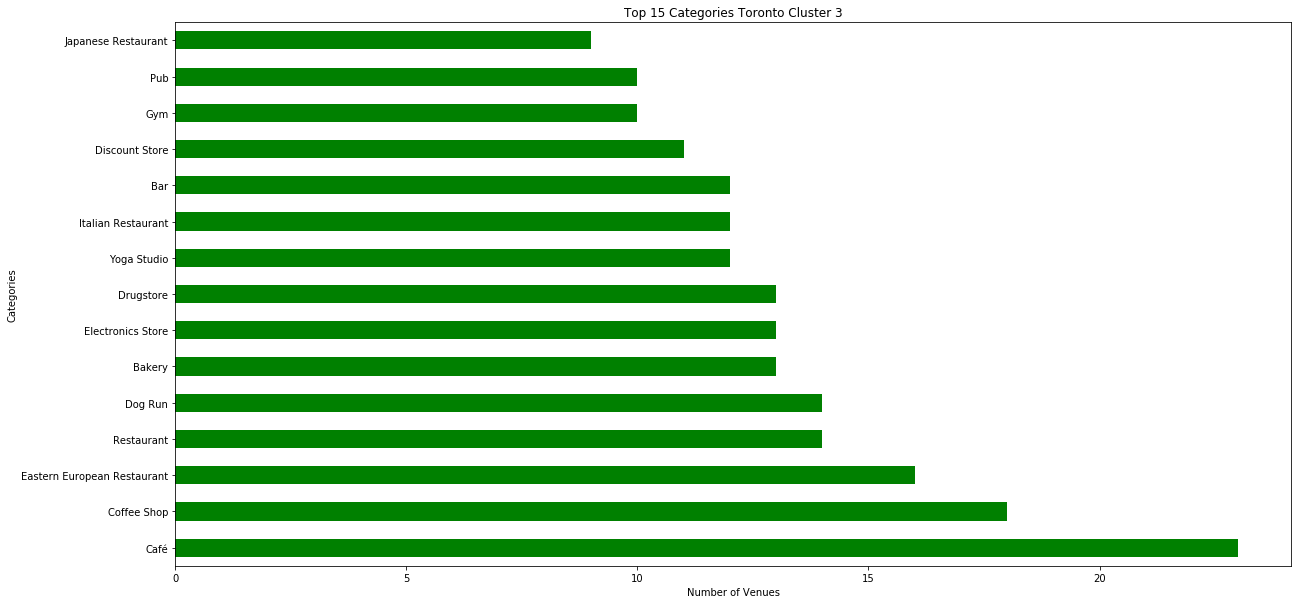

In [277]:
import matplotlib.pyplot as plt

o1g1=o1.iloc[0:15,]
o1g1.set_index('categ',inplace=True)


o1g1.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),legend= False, color= 'g'# pass a tuple (x, y) size,legend= False
             )

plt.title('Top 15 Categories Toronto Cluster 3')
plt.ylabel('Categories')
plt.xlabel('Number of Venues')

plt.show()

##### Data is concentrated around 3

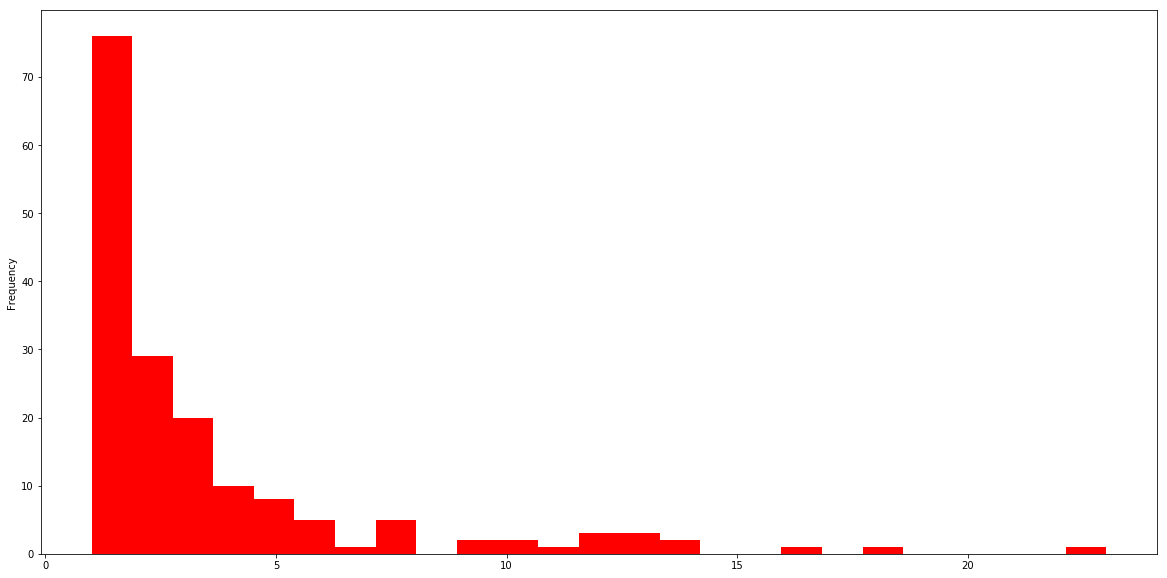

In [278]:
o1.plot(kind='hist',figsize=(20, 10),color='r',bins=25,legend= False) 

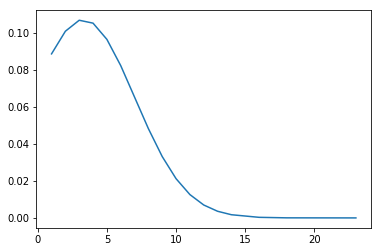

In [279]:
import scipy.stats as stats
import matplotlib.pyplot as plt

hh=o1["clot3"]
hmean = np.mean(hh)
hstd = np.std(hh)
pdf = stats.norm.pdf(hh, hmean, hstd)
plt.plot(hh, pdf)

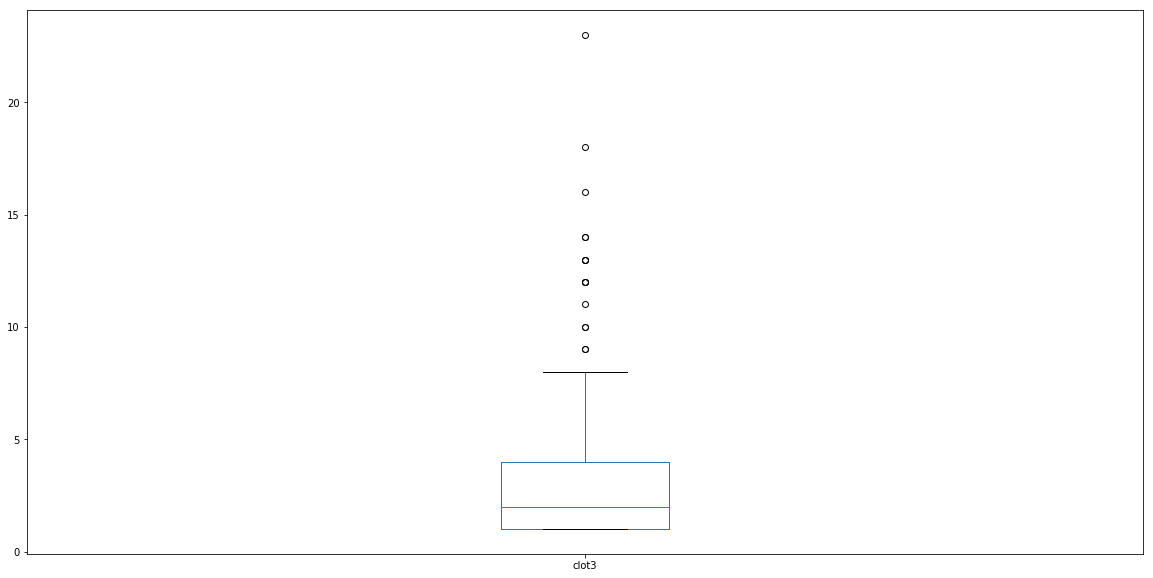

In [280]:
o1.plot(kind='box',figsize=(20, 10)) 

In [281]:
## Decriptive Satistics
h1.describe()

,clot3
count,170.000000
mean,3.294118
std,3.736351
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,23.000000


#### Data for Toronto Cluster 3, our target, is concentrated around 3 venues for the same category, although there are some outliers which is our client's most common type of client, as we could see by the sorted tables. Therefore, threshold will be 3 for classification (y variable)

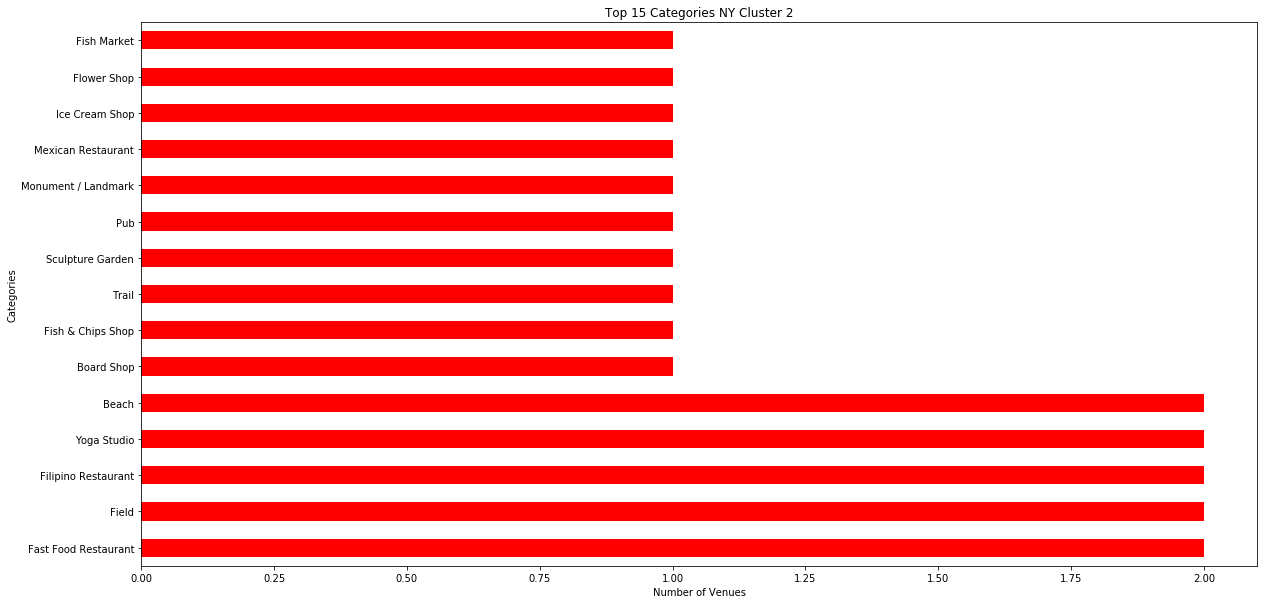

In [282]:

o1g1=o2.iloc[0:15,]
o1g1.set_index('categ',inplace=True)


o1g1.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),legend= False, color= 'r'# pass a tuple (x, y) size,legend= False
             )

plt.title('Top 15 Categories NY Cluster 2')
plt.ylabel('Categories')
plt.xlabel('Number of Venues')

plt.show()

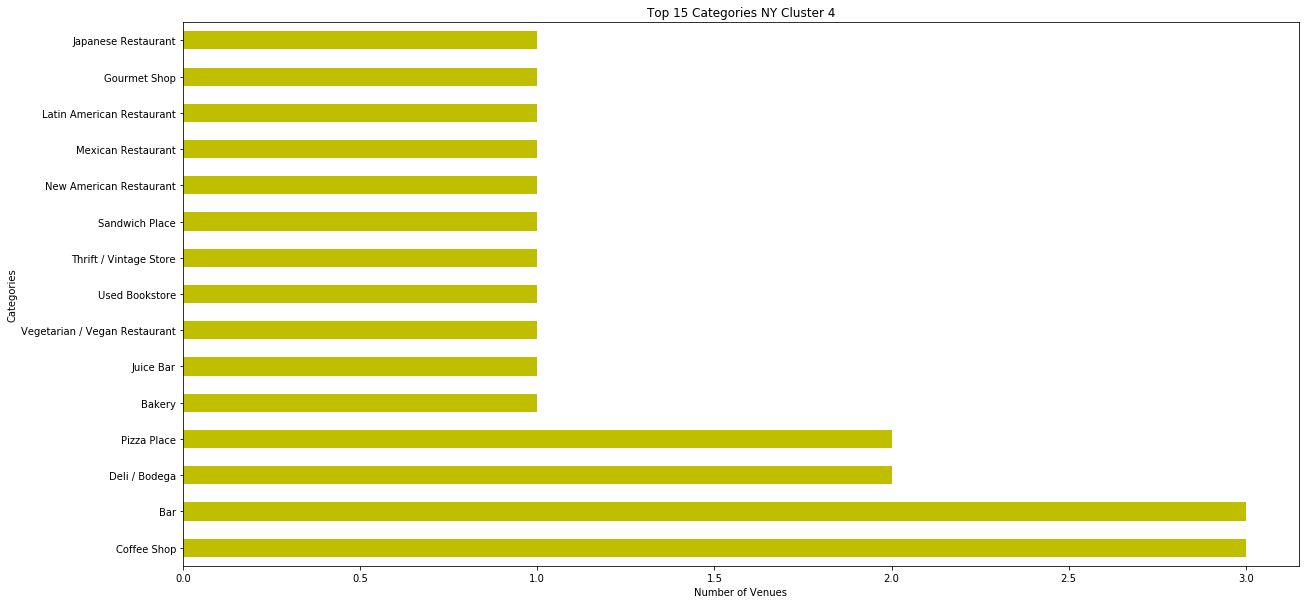

In [283]:

o1g1=o4.iloc[0:15,]
o1g1.set_index('categ',inplace=True)


o1g1.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),legend= False, color= 'y'# pass a tuple (x, y) size,legend= False
             )

plt.title('Top 15 Categories NY Cluster 4')
plt.ylabel('Categories')
plt.xlabel('Number of Venues')

plt.show()

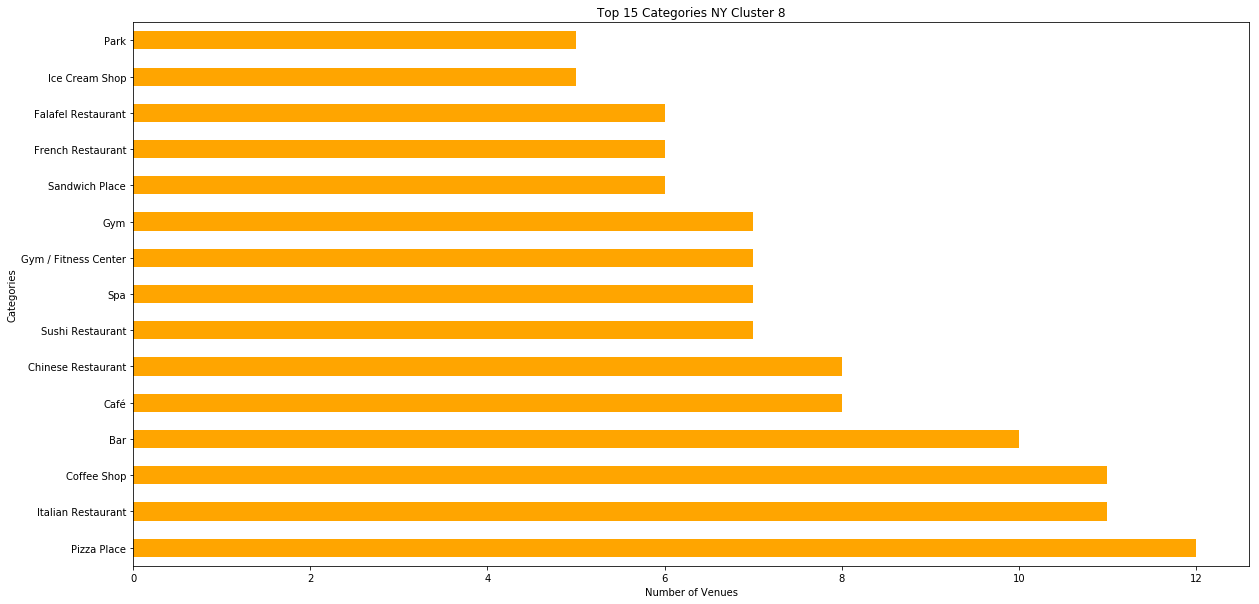

In [284]:

o1g1=o8.iloc[0:15,]
o1g1.set_index('categ',inplace=True)


o1g1.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10),legend= False, color= 'Orange'# pass a tuple (x, y) size,legend= False
             )

plt.title('Top 15 Categories NY Cluster 8')
plt.ylabel('Categories')
plt.xlabel('Number of Venues')

plt.show()

## Modeling 

#### Data Preparation for modeling

In [285]:
y = np.asarray(dfcl3['A'])
y [0:5]

X = np.asarray( dfcl3[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])
X[0:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [286]:
#normalizando
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.34, -0.48, -0.49,  1.03, -0.51, -0.47, -0.43, -0.44, -0.43,
        -0.44],
       [-0.34, -0.48, -0.49, -0.51, -0.51, -0.47, -0.43, -0.44, -0.43,
         0.9 ],
       [ 0.68, -0.48, -0.49, -0.51, -0.51, -0.47, -0.43, -0.44, -0.43,
        -0.44],
       [-0.34,  0.98, -0.49, -0.51, -0.51, -0.47, -0.43, -0.44, -0.43,
        -0.44],
       [-0.34, -0.48,  0.99, -0.51, -0.51, -0.47, -0.43, -0.44, -0.43,
        -0.44]])

In [287]:
#split Train/Test Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136, 10) (136,)
Test set: (34, 10) (34,)


### Logistic Model

In [288]:
######Modeling
#This function implements logistic regression and can use.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [289]:
yhat = LR.predict(X_test)
yhat


array([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

In [290]:
##In probabilities
#predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):
yhat_prob = LR.predict_proba(X_test)


### Decision Tree Model

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [292]:
drugTree.fit(X_trainset,y_trainset)
predTree = drugTree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])


[0. 0. 1. 0. 1.]
[0. 0. 1. 1. 1.]


## Model Evaluation

#### Losgistic Regression evaluation

In [293]:
#jaccard index (classificaton erro metic)
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9411764705882353

In [294]:
#confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#print(confusion_matrix(y_test, yhat, labels=[1,0]))

Confusion matrix, without normalization
[[ 9  2]
 [ 0 23]]


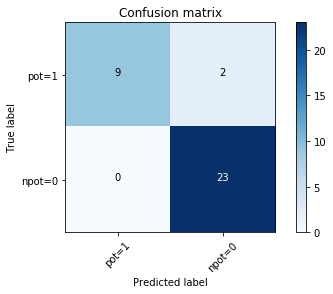

In [295]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['pot=1','npot=0'],normalize= False,  title='Confusion matrix')

In [296]:
# confusion Matrix metrics for logistic

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        23
         1.0       1.00      0.82      0.90        11

   micro avg       0.94      0.94      0.94        34
   macro avg       0.96      0.91      0.93        34
weighted avg       0.95      0.94      0.94        34



In [297]:
##Log Loss
#In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1. Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5036347810297219

In [298]:
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.metrics import mean_squared_error

r2test=r2_score((yhat),(y_test))
rmsetest=sqrt(mean_squared_error(yhat,y_test))
print('Test Rmse:%.5f' % rmsetest)
print('Test R2:%.3f' % r2test)

Test Rmse:0.24254
Test R2:0.698


#### Decision Tree evaluation


In [299]:
jaccard_similarity_score(y_testset, predTree )

0.7843137254901961

Confusion matrix, without normalization
[[12 11]
 [ 0 28]]


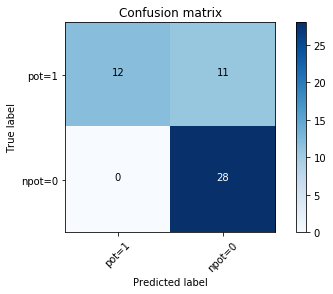

In [300]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, predTree, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['pot=1','npot=0'],normalize= False,  title='Confusion matrix')

In [301]:
# confusion Matrix metrics

print(classification_report(y_testset, predTree))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84        28
         1.0       1.00      0.52      0.69        23

   micro avg       0.78      0.78      0.78        51
   macro avg       0.86      0.76      0.76        51
weighted avg       0.85      0.78      0.77        51



#### Logistic Regression presented better results than the Decision Tree Model. So, for this sample, LR seems to be a better classifier

## Predictive

### Classification for NY Clusters selected: 2,4 and 8: Proportion of how many categories are adherent to client's product for each NY cluster

#### Prediction using LR model

In [302]:
i2=g2.reset_index()

ih=i2.loc[i2.iloc[:,0].isin(dfcl3['categ'])]

In [303]:
len(dfcl3)

170

In [304]:
i2=g2.reset_index()
ih=i2.loc[i2.iloc[:,0].isin(dfcl3['categ'])]

X2 = np.asarray( ih[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

X2 = preprocessing.StandardScaler().fit(X2).transform(X2)

yhat2 = LR.predict(X2)

## proportion of categ that might be a client
clny2prop=sum(yhat2)/len(yhat2)
print("Proportion of categ that might be a client adherent:",round(clny2prop,3)*100,'\n', "Cluster Size:", o2['clny2'].sum(),'\n', "Potential clients:",round(clny2prop*o2['clny2'].sum()))

Proportion of categ that might be a client adherent: 22.2 
 Cluster Size: 30.0 
 Potential clients: 7.0


In [305]:
i4=g4.reset_index()
ih=i4.loc[i4.iloc[:,0].isin(dfcl3['categ'])]

X4 = np.asarray( g4[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])

X4 = preprocessing.StandardScaler().fit(X4).transform(X4)

yhat4 = LR.predict(X4)

## proportion of categ that might be a client
clny4prop=sum(yhat4)/len(yhat4)
print("Proportion of categ that might be a client adherent:",round(clny4prop,2)*100,'\n', "Cluster Size:", o4['clny4'].sum(),'\n', "Potential clients:",round(clny4prop*o4['clny4'].sum()))

Proportion of categ that might be a client adherent: 17.0 
 Cluster Size: 30.0 
 Potential clients: 5.0


In [306]:
i8=g8.reset_index()
ih=i8.loc[i8.iloc[:,0].isin(dfcl3['categ'])]

X8 = np.asarray( g8[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']])


X8 = preprocessing.StandardScaler().fit(X8).transform(X8)
yhat8 = LR.predict(X8)


## proportion of categ that might be a client
clny8prop=sum(yhat8)/len(yhat8)

print("Proportion of categ that might be a client adherent:",round(clny8prop,2)*100,'\n', "Cluster Size:", o8['clny8'].sum(),'\n', "Potential clients:",round(clny8prop*o8['clny8'].sum()))

Proportion of categ that might be a client adherent: 23.0 
 Cluster Size: 350.0 
 Potential clients: 82.0


#### Prediction using Decision Tree

In [307]:
predTree2 = drugTree.predict(X2)
## proportion of categ that might be a client
clny2prop=sum(predTree2)/len(predTree2)
print("Proportion of categ that might be a client adherent:",round(clny2prop,3)*100,'\n', "Cluster Size:", o2['clny2'].sum(),'\n', "Potential clients:",round(clny2prop*o2['clny2'].sum()))

Proportion of categ that might be a client adherent: 5.6000000000000005 
 Cluster Size: 30.0 
 Potential clients: 2.0


In [308]:
predTree4 = drugTree.predict(X4)
## proportion of categ that might be a client
clny4prop=sum(predTree4)/len(predTree4)
print("Proportion of categ that might be a client adherent:",round(clny4prop,3)*100,'\n', "Cluster Size:", o4['clny4'].sum(),'\n', "Potential clients:",round(clny4prop*o4['clny4'].sum()))

Proportion of categ that might be a client adherent: 8.3 
 Cluster Size: 30.0 
 Potential clients: 2.0


In [309]:
predTree8 = drugTree.predict(X8)
## proportion of categ that might be a client
clny8prop=sum(predTree8)/len(predTree8)
print("Proportion of categ that might be a client adherent:",round(clny8prop,3)*100,'\n', "Cluster Size:", o8['clny8'].sum(),'\n', "Potential clients:",round(clny8prop*o8['clny8'].sum()))

Proportion of categ that might be a client adherent: 14.399999999999999 
 Cluster Size: 350.0 
 Potential clients: 50.0


## Conclusion
### Although proportion is not so different between NY Cluster predictions (classification of venue categories that might be client's custmers), even for the types of models, NY Cluster 2 seems to be the location target with more potential